## Super-resolve output

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.backends.cudnn as cudnn
from PIL import Image

from torchvision.transforms import ToTensor
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

#from skimage.measure import compare_psnr as psnr
#from skimage.measure import compare_ssim as ssim

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as utils

In [5]:
# Path to data

#low_res_img_path = '../dataset/300W-3D-crap-56/test/AFW_37096733_1.jpg'
#original_img_path = '../dataset/300W-3D-low-res-22/test/AFW_37096733_1.jpg'

#low_res_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-low-res-56/test/AFW_37096733_1.jpg'
#original_img_path = '/media/angelo/DATEN/Datasets/Experiment_Masters/300W-3D-low-res-224/test/AFW_37096733_1.jpg'

low_res_img_path = '/media/angelo/DATEN/Datasets/CelebA/LR_56/test/018010.jpg'
original_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018010.jpg'

#model_path = 'models/SubCNN_coord_x4_epoch_20.pth'
model_path = 'models/SRCNN_coord_x4_epoch_50.pth'

In [6]:
# Input Image Setting

GPU_IN_USE = torch.cuda.is_available()

# For SRCNN and VDSR
img = Image.open(low_res_img_path).convert('YCbCr').resize((224,224), Image.BICUBIC)

#For SubPixelCNN
#img = Image.open(low_res_img_path).convert('YCbCr')
y, cb, cr = img.split()

In [7]:
# Input image setting

device = torch.device('cuda' if GPU_IN_USE else 'cpu')
model = torch.load(model_path, map_location=lambda storage, loc: storage)
model = model.to(device)
data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
#data = (ToTensor()(img)).view(1, 3, img.size[1], img.size[0])
data = data.to(device)

if GPU_IN_USE:
    cudnn.benchmark = True

In [26]:
# Output and save image

out = model(data)
out = out.cpu()
out_img_y = out.data[0].numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb
out_img_cr = cr

#out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
#out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)

out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

#out_img.save('result.png')

PSNR and SSIM BICUBIC: 27.037 and 0.770
PSNR and SSIM MODEL:   26.836 and 0.770


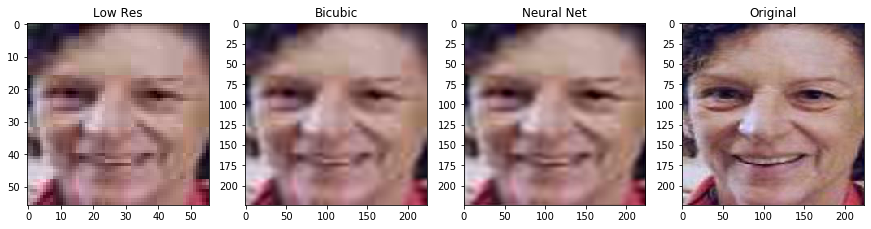

In [27]:
# Checking image quality

real_img = Image.open(original_img_path)
bicubic_img = Image.open(low_res_img_path).resize((224,224),resample=Image.BICUBIC)

# PSNR and SSIM - Bilinear Interpolation

print('PSNR and SSIM BICUBIC: %.3f and %.3f' %(psnr(np.array(bicubic_img), np.array(real_img)), 
                                               ssim(np.array(bicubic_img), np.array(real_img), multichannel=True)))
print('PSNR and SSIM MODEL:   %.3f and %.3f' %(psnr(np.array(out_img), np.array(real_img)), 
                                               ssim(np.array(out_img), np.array(real_img), multichannel=True)))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.gca().set_title('Low Res')
plt.imshow(Image.open(low_res_img_path))
plt.subplot(1,4,2)
plt.gca().set_title('Bicubic')
plt.imshow(bicubic_img)
plt.subplot(1,4,3)
plt.gca().set_title('Neural Net')
plt.imshow(out_img)
plt.subplot(1,4,4)
plt.gca().set_title('Original')
plt.imshow(real_img)
plt.show()